# Project 2: NYC Taxi Rides
# Part 4:  Feature Engineering and Model Fitting

In this final part of the project, you will finally build a regression model that attempts to predict the duration of a taxi ride from all other available information.

You will build this model using a processing pipeline and submit your results to Kaggle. We will first walk you through a generic example using the data we saved from Part 1. Please carefully follow these steps as you will need to repeat this for your final model. After, we give you free reign and let you decide how you want to define your final model.

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

## Training and Validation

The following code loads the training and validation data from part 1 into a Pandas DataFrame.

In [2]:
# Run this cell to load the data. 
data_file = Path("./", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")
val_df = pd.read_hdf(data_file, "val")

## Testing
Here we load our testing data on which we will evaluate your model.

In [3]:
test_df = pd.read_csv("./proj2_test_data.csv")
test_df['tpep_pickup_datetime'] = pd.to_datetime(test_df['tpep_pickup_datetime'])
test_df.head()

,record_id,VendorID,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,10000,1,2016-01-02 01:45:37,1,1.20,-73.982224,40.768620,1,N,-73.983765,40.779598,1,6.0,0.5,0.5,2.00,0.0,0.3,9.30
1,19000,2,2016-01-02 03:05:16,1,10.90,-73.999977,40.738121,1,N,-73.888657,40.824364,1,31.5,0.5,0.5,6.56,0.0,0.3,39.36
2,21000,1,2016-01-02 03:24:36,1,1.80,-73.986618,40.747379,1,N,-73.978508,40.729622,1,8.5,0.5,0.5,1.96,0.0,0.3,11.76
3,23000,2,2016-01-02 03:47:38,1,5.95,-74.002922,40.744572,1,N,-73.942413,40.786419,1,20.5,0.5,0.5,4.36,0.0,0.3,26.16
4,27000,1,2016-01-02 04:36:44,1,1.60,-73.986366,40.759464,1,N,-73.963081,40.760353,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30


In [4]:
test_df.describe()

,record_id,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.377400e+04,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000,13774.000000
mean,3.465950e+07,1.536082,1.663642,2.954688,-72.953619,40.187999,1.043778,-73.055577,40.245056,1.340061,12.836930,0.333091,0.497985,1.805420,0.304031,0.299652,16.077391
std,2.015133e+07,0.498714,1.311739,3.704427,8.628431,4.753186,0.877637,8.191366,4.512564,0.490019,10.707619,0.429590,0.036632,2.416784,1.363097,0.013522,13.206231
min,1.000000e+04,1.000000,0.000000,0.000000,-77.039436,0.000000,1.000000,-77.039436,0.000000,1.000000,-93.300000,-0.500000,-0.500000,0.000000,0.000000,-0.300000,-93.600000
25%,1.719975e+07,1.000000,1.000000,1.000000,-73.992058,40.735166,1.000000,-73.991318,40.734002,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000
50%,3.457400e+07,2.000000,1.000000,1.700000,-73.981846,40.752432,1.000000,-73.979897,40.753263,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000
75%,5.216875e+07,2.000000,2.000000,3.157500,-73.967119,40.767264,1.000000,-73.962749,40.768455,2.000000,14.500000,0.500000,0.500000,2.360000,0.000000,0.300000,17.800000
max,6.940400e+07,2.000000,6.000000,104.800000,0.000000,40.868210,99.000000,0.000000,41.540859,4.000000,156.040000,4.500000,1.740000,40.000000,20.000000,0.300000,187.590000


# Modeling

We've finally gotten to a point where we can specify a simple model. Remember that we will be fitting our model on the training set we created in part 1. We will use our validation set to evaluate how well our model might perform on future data.

### Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, this should be sufficient motivation to abstract parts of our code into reusable functions/methods.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model".

In [5]:
# Copied from part 2
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

In [6]:
def process_data_gm1(data, test=False):
    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        
        .pipe(select_columns,        
              'pickup_longitude',  
              'pickup_latitude',   
              'dropoff_longitude', 
              'dropoff_latitude',
              'manhattan',
             )
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y

We will use our pipeline defined above to pre-process our training and test data in exactly the same way. Our functions make this relatively easy to do!

In [7]:
# Train
X_train, y_train = process_data_gm1(train_df)
X_val, y_val = process_data_gm1(val_df)
guided_model_1 = lm.LinearRegression(fit_intercept=True)
guided_model_1.fit(X_train, y_train)

# Predict
y_train_pred = guided_model_1.predict(X_train)
y_val_pred = guided_model_1.predict(X_val)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


Here, `y_val` are the correct durations for each ride, and `y_val_pred` are the predicted durations based on the 7 features above (`vendorID`, `passenger_count`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `manhattan`).

In [8]:
assert 600 <= np.median(y_train_pred) <= 700
assert 600 <= np.median(y_val_pred) <= 700

The resulting model really is a linear model just like we saw in class, i.e. the predictions are simply generated by the product $\Phi\theta$. For example, the line of code below generates a prediction for $x_1$ by computing $\phi_1^T\theta$. Here `guided_model_1.coef_` is $\theta$ and `X_train.iloc[0, :]` is $\phi_1$.

Note that unlike in class, here the dummy intercept term is not included in $\Phi$. 

In [9]:
X_train.iloc[0, :].dot(guided_model_1.coef_) + guided_model_1.intercept_

558.75133051135344

We see that this prediction is exactly the same (except for possible floating point error) as generated by the `predict` function, which simply computes the product $\Phi\theta$, yielding predictions for every input.

In [10]:
y_train_pred[0]

558.751330511368

In this assignment, we will use Mean Absolute Error (MAE), a.k.a. mean L1 loss, to measure the quality of our models.  As a reminder, this quantity is defined as:

$$
MAE =\frac{1}{n}\sum_{i}  | y_i -\hat{y_i}|
$$

Why may we want to use the MAE as a metric, as opposed to Mean Squared Error (MSE)? Using our domain knowledge that most rides are short in duration (median is roughly 600 seconds), we know that MSE is susceptible to outliers. Given that some of the outliers in our dataset are quite extreme, it is probably better to optimize for the majority of rides rather than for the outliers. You may want to remove some of these outliers later on.

In [11]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

In [12]:
assert 200 <= mae(y_val_pred, y_val) <= 300
print("Validation Error: ", mae(y_val_pred, y_val))

Validation Error:  266.136130855


Side note: scikit-learn also has tools to compute mean absolute error (`sklearn.metrics.mean_absolute_error`). In fact, most metrics that we have discussed in this class can be found as part of the [`sklearn.metrics` module](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics). Some of these may come in handy as part of your feature engineering!

## Visualizing Error
You should be getting between 200 and 300 MAE, which means your model was off by roughly 3-5 minutes on trips of average length 12 minutes. This is fairly decent performance given that our basic model uses only using the pickup/dropoff latitude and manhattan distance of the trip. 3-5 minutes may seem like a lot for a trip of 12 minutes, but keep in mind that this is the *average* error. This metric is susceptible to extreme outliers, which exist in our dataset. 

Now we will visualize the residual for the validation set. We will plot the following:

1. Distribution of residuals
2. Average residual grouping by ride duration


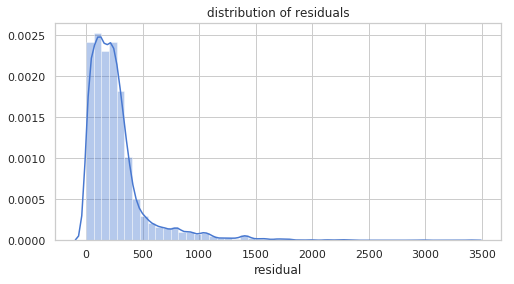

In [13]:
# Distribution of residuals
plt.figure(figsize=(8,4))
sns.distplot(np.abs(y_val - y_val_pred))
plt.xlabel('residual')
plt.title('distribution of residuals');

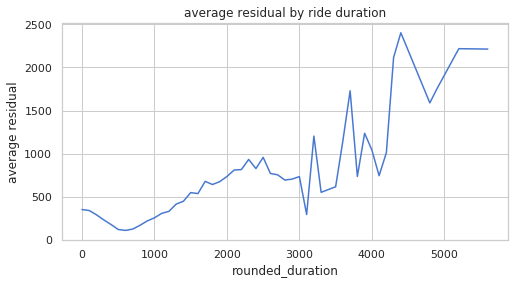

In [14]:
# Average residual grouping by ride duration
val_residual = X_val.copy()
val_residual['duration'] = y_val
val_residual['rounded_duration'] = np.around(y_val, -2)
val_residual['residual'] = np.abs(y_val - y_val_pred)
tmp = val_residual.groupby('rounded_duration').mean()
plt.figure(figsize=(8,4))
tmp['residual'].plot()
plt.ylabel('average residual')
plt.title('average residual by ride duration');

In the first visualization, we see that most of the residuals are centered around 250 seconds ~ 4 minutes. There is a minor right tail, suggesting that we are still unable to accurately fit some outliers in our data. The second visualization also suggests this, as we see the average residual increasing as a somewhat linear function of duration. But given that our average ride duration is roughly 600-700 seconds, it seems that we are indeed optimizing for the average ride because the residuals are smallest around 600-700. 

Keep this in mind when creating your final model! Visualizing the error is a powerful tool and may help diagnose shortcomings of your model. Let's go ahead and submit to kaggle, although your error on the test set may be higher than 300. 

# Submission to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs, but we recommend you make a copy and preserve the original function.

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the columns `pickup_datetime` or `pickup_latitude` on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

In [15]:
from datetime import datetime
def generate_submission(test, predictions, force=False):
    if force:
        if not os.path.isdir("submissions"):
            os.mkdir("submissions")
        submission_df = pd.DataFrame({
            "id": test_df.index.values, 
            "duration": predictions,
        },
            columns=['id', 'duration'])

        timestamp = datetime.isoformat(datetime.now()).split(".")[0]

        submission_df.to_csv(f'submissions/submission_{timestamp}.csv', index=False)

        print(f'Created a CSV file: submission_{timestamp}.csv')
        print('You may now upload this CSV file to Kaggle for scoring.')

In [16]:
X_test, _ = process_data_gm1(test_df, True)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [17]:
assert list(X_train.columns) == list(X_test.columns), "Different columns or different column ordering"
submission_predictions = (guided_model_1
                          .fit(X_train, y_train)
                          .predict(X_test))
submission_predictions = submission_predictions.astype(int)
submission_predictions[submission_predictions < 0] = 0
generate_submission(test_df, submission_predictions, True)

Created a CSV file: submission_2018-11-20T20:31:16.csv
You may now upload this CSV file to Kaggle for scoring.


In [18]:
# Check your submission
assert isinstance(submission_predictions, np.ndarray), "Submission not an array"
assert all(submission_predictions >= 0), "Duration must be non-negative"
assert issubclass(submission_predictions.dtype.type, np.integer), "Seconds must be integers"

## Your Turn!

Now it's your turn! Draw upon everything you have learned this semester to find the best features to help your model accurately predict the duration of a taxi ride.

You may use whatever method you prefer in order to create features. You may use features that we created and features that you discovered yourself from any of the 2 datasets. However, we want to make it fair to students who are seeing these techniques for the first time. As such, you are only allowed regression models and their regularized forms. This means no random forest, k-nearest-neighbors, neural nets, etc.

**Here are some ideas to improve your model:**
- **Data selection**: January 2016 was an odd month for taxi rides due to the blizzard. Would it help to select training data differently?
- **Data cleaning**: Try cleaning your data in different ways. In particular, consider how to handle outliers. 
- **Better features**: Explore the 2 datasets and find what features are most helpful. Utilize external datasets to improve your accuracy. 
- **Regularization**: Try different forms of regularization to avoid fitting to the training set. Recall that `Ridge` and `Lasso` are the names of the classes in `sklearn.linear_model` that combine `LinearRegression` with regularization techniques.
- **Model selection**: You can adjust parameters of your model (e.g., the regularization parameter) to achieve higher accuracy. [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) may be helpful.
- **Validation**: Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

There's many things you could try that could help your model. We have only suggested a few. Be creative and innovative! Please use `proj2_extras.ipynb` for all of your extraneous work. Note that you will be submitting `proj2_extras.ipynb` and we will be grading it. Please properly comment and format this notebook!

Once you are satisfied with your results, answer the questions in the Deliverables section. You may want to read this section in advance so you have an idea of what we're looking for.

## Deliverables

## Feature/Model Selection Process

Let's first look at selection of better features. In this following cell, describe the process of choosing good features to improve your model. You should use at least 3-4 sentences each to address the follow questions. Backup your responses with graphs supporting your claim (you can save figures and load them, no need to add the plotting code here). Use these questions to concisely summarize all of your extra work!

### Question 1a
How did you find better features for your model?

In [19]:
q1a_answer = r"""

Put your answer here, replacing this text. Do not take into account the ### YOUR CODE HERE below

"""
### BEGIN SOLUTION
### END SOLUTION

### Question 1b
What did you try that worked / didn't work?

In [20]:
q1b_answer = r"""

Put your answer here, replacing this text. Do not take into account the ### YOUR CODE HERE below

"""
### BEGIN SOLUTION
### END SOLUTION

### Question 1c

What was surprising in your search for good features?

In [21]:
q1c_answer = r"""

Put your answer here, replacing this text. Do not take into account the ### YOUR CODE HERE below

"""
### BEGIN SOLUTION
### END SOLUTION

### Question 2

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible.  Define `process_data_fm` and `final model` in the cell below.  In order to calculate your final model's MAE, we will run the code in the cell after that.

**Note:** You *MUST* name the model you wish to be evaluated on `final_model`. This is what we will be using to generate your predictions. We will take the state of `final_model` right after executing the cell below and run the following code:

```
# Load in test_df, solutions
X_test, _ = process_data_fm(test_df, True)
submission_predictions = final_model.predict(X_test)
# Generate score for autograding
```

We encourage you to conduct all of your exploratory work in `proj2_extras.ipynb`, which will be graded for 10 points.

In [22]:
def process_data_fm(data, test=False):
    # Put your final pipeline here
    ...
    
final_model = ... # Define your final model here, feel free to try other forms of regression
# final_model.fit(...)

### BEGIN SOLUTION
def remove_outliers(data, outlier_col, test=False):
    if test:
        return data
    if outlier_col == "duration":
        return data[(data['duration'] < np.percentile(data['duration'], 80)) & (data['duration'] > np.percentile(data['duration'], 20))]
    elif outlier_col == "manhattan":
        return data[(data['manhattan'] < np.percentile(data['manhattan'], 80)) & (data['manhattan'] > np.percentile(data['manhattan'], 20))]
    elif outlier_col == "haversine":
        return data[(data['haversine'] < np.percentile(data['haversine'], 80)) & (data['haversine'] > np.percentile(data['haversine'], 20))]
    elif outlier_col == "bearing":
        return data[(data['bearing'] < np.percentile(data['bearing'], 80)) & (data['bearing'] > np.percentile(data['bearing'], 20))]

def process_data_fm(data, test=False):
    if test:
        X = (
            data

            # Transform data
            .pipe(add_time_columns)
            .pipe(add_distance_columns)

            .pipe(select_columns, 
                  'VendorID',        
                  'passenger_count',            
                  'pickup_longitude',  
                  'pickup_latitude',   
                  'dropoff_longitude', 
                  'dropoff_latitude',
                  'manhattan',
                  'bearing',
                  'haversine',
                  'hour',
                  'week_hour',
                 )
        )
        return X, None
    data = (
        data
        # Remove temporal outliers
        .pipe(remove_outliers, 'duration', test)
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        
        # Remove spatial outliers
        .pipe(remove_outliers, 'manhattan', test)
        .pipe(remove_outliers, 'bearing', test)
        .pipe(remove_outliers, 'haversine', test)
        
        .pipe(select_columns, 
              'VendorID',        
              'passenger_count',            
              'pickup_longitude',  
              'pickup_latitude',   
              'dropoff_longitude', 
              'dropoff_latitude',
              'manhattan',
              'duration',
              'bearing',
              'haversine',
              'hour',
              'week_hour',
             )
    ) 

    # Return predictors and response variables separately
    X = data.drop(['duration'], axis = 1)
    y = data['duration']
    
    return X, y

X_train, y_train = process_data_fm(train_df)
X_val, y_val = process_data_fm(val_df)
final_model = lm.Ridge(fit_intercept=True)


final_model.fit(X_train, y_train);
### END SOLUTION

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [23]:
# Feel free to change this cell
X_test, _ = process_data_fm(test_df, True)
final_predictions = final_model.predict(X_test)
final_predictions = final_predictions.astype(int)
generate_submission(test_df, final_predictions, False) # Change to true to generate prediction

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


### Question 3
The following hidden cells will test your model on the test set. Please do not delete any of them if you want credit!

In [24]:
# NO TOUCH
### BEGIN HIDDEN TESTS
solutions_df = pd.read_csv("/srv/db/proj2_test_solutions.csv")
solutions_df['tpep_dropoff_datetime'] = pd.to_datetime(solutions_df['tpep_dropoff_datetime'])
solutions_df['tpep_pickup_datetime'] = pd.to_datetime(solutions_df['tpep_pickup_datetime'])
solutions_df['duration'] = solutions_df['tpep_dropoff_datetime'] - solutions_df['tpep_pickup_datetime']
solutions_df['duration'] = solutions_df['duration'].dt.total_seconds()

y_true = solutions_df['duration']
y_true = y_true.astype(int)

X_test, _ = process_data_fm(test_df, True)
submission_predictions = final_model.predict(X_test)
submission_predictions = submission_predictions.astype(int)
submission_predictions[submission_predictions < np.percentile(submission_predictions, 5)] = np.percentile(submission_predictions, 5)
submission_predictions[submission_predictions > np.percentile(submission_predictions, 95)] = np.percentile(submission_predictions, 95)
score = mae(submission_predictions, y_true)
print("Score: ", score)
### END HIDDEN TESTS

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


Score:  413.679976768


In [25]:
# NOH
### BEGIN HIDDEN TESTS
assert score < np.inf
### END HIDDEN TESTS

In [26]:
# STAHP
### BEGIN HIDDEN TESTS
assert score <= 1000
### END HIDDEN TESTS

In [27]:
# NO MOLESTE
### BEGIN HIDDEN TESTS
assert score <= 950
### END HIDDEN TESTS

In [28]:
# VA-T'EN
### BEGIN HIDDEN TESTS
assert score <= 900
### END HIDDEN TESTS

In [29]:
# NEIN
### BEGIN HIDDEN TESTS
assert score <= 850
### END HIDDEN TESTS

In [30]:
# PLSNO
### BEGIN HIDDEN TESTS
assert score <= 800
### END HIDDEN TESTS

In [31]:
# THIS SPACE IS NOT YOURS
### BEGIN HIDDEN TESTS
assert score <= 750
### END HIDDEN TESTS

In [32]:
# TAWDEETAW
### BEGIN HIDDEN TESTS
assert score <= 700
### END HIDDEN TESTS

In [33]:
# MAU LEN
### BEGIN HIDDEN TESTS
assert score <= 650
### END HIDDEN TESTS

In [34]:
# ALMOST
### BEGIN HIDDEN TESTS
assert score <= 600
### END HIDDEN TESTS

In [35]:
# TO
### BEGIN HIDDEN TESTS
assert score <= 550
### END HIDDEN TESTS

In [36]:
# THE
### BEGIN HIDDEN TESTS
assert score <= 500
### END HIDDEN TESTS

In [37]:
# END
### BEGIN HIDDEN TESTS
assert score <= 450
### END HIDDEN TESTS

In [38]:
# Hmph
### BEGIN HIDDEN TESTS
assert score <= 400
### END HIDDEN TESTS

AssertionError: 

In [ ]:
# Good riddance
### BEGIN HIDDEN TESTS
assert score <= 350
### END HIDDEN TESTS

In [ ]:
generate_submission(test_df, submission_predictions, True)

This should be the format of your CSV file.  
Unix-users can verify it running `!head submission_{datetime}.csv` in a jupyter notebook cell.
![sample_submission_format](figs/sample_submission_format.png)

Kaggle link: https://www.kaggle.com/t/f8b3c6acc3a045cab152060a5bc79670